In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections
import jax
import jax.numpy as jnp
from jax import grad, value_and_grad
from jax import jit, lax
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

from cartpolejax import JAXCartPole
from cartpolejax import loss as jax_loss

999.9999999943412
999.9999999943412


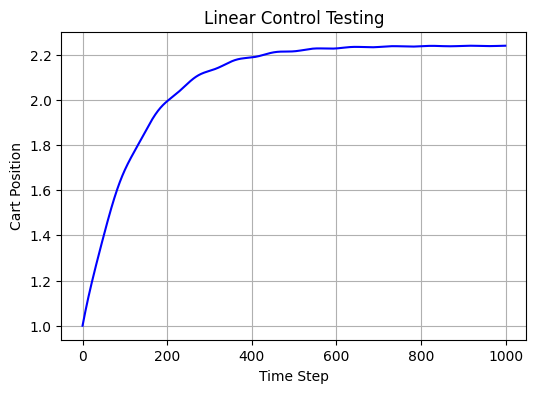

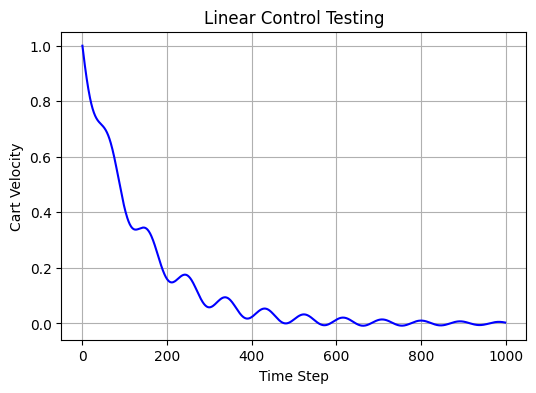

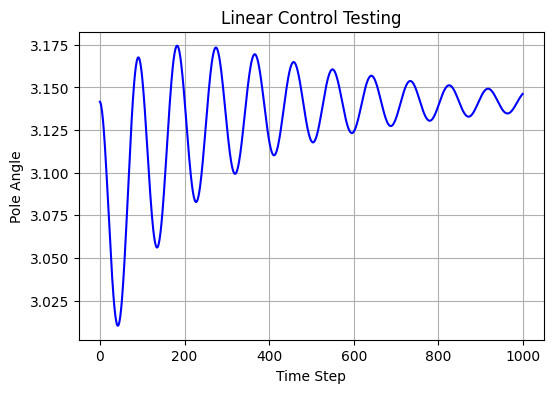

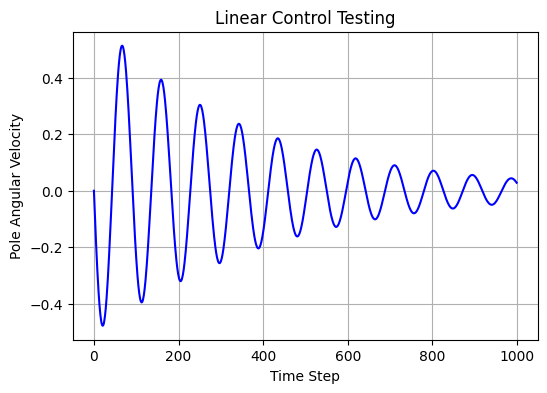

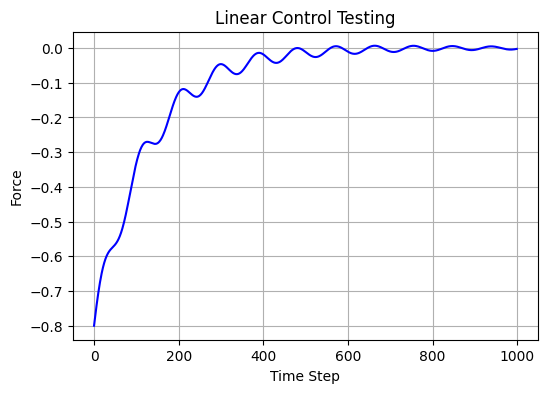

In [91]:
# verify over a short time horizon of 3 seconds (1-2 oscillation periods)
stationary = np.array([1.0, 1.0, np.pi, 0.0])
p = np.array([0.0, -0.8, 0.0, 0.0])
loss, states = rollout_loss_states(stationary, p, 10, env)
print(rollout_loss(stationary, p, 10, env))
print(loss)

# time, state = enumerate(states)
labels = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity', 'Force']
title = 'Linear Control Testing'


for i in range(5):
    plt.figure(figsize=(6, 4))
    plt.plot(states[:, i], label='True Evolution', color='blue')
    plt.title(title)
    plt.ylabel(labels[i])
    plt.xlabel('Time Step')
    plt.grid(True)
    # plt.savefig(f"1.4_smallosc_{labels[i].replace(' ', '_').lower()}_vs_time.png")

### Loss Landscape

In [86]:
# angle: clockwise as positive
num_scan = 100
cart_pos = 0.2
cart_vel = 0.0
pole_ang = 0.2
pole_vel = 0.0
init_state = np.array([cart_pos, cart_vel, pole_ang, pole_vel])

p_cp = 0.78
p_cv = 1.43
# p_pa = 17.04
# p_pv = 2.65
p_pa_scan = np.linspace(10, 20, num_scan)
p_pv_scan = np.linspace(1, 4, num_scan)

P_PA, P_PV = np.meshgrid(p_pa_scan, p_pv_scan)
P_PA = P_PA.ravel()
P_PV = P_PV.ravel()

X = []
Loss = []

prt = 0

for p_pa, p_pv in zip(P_PA, P_PV):
    p = np.array([p_cp, p_cv, p_pa, p_pv])
    if prt < 10:
        print(p)
        prt += 1
    loss = rollout_loss(init_state, p, 3, env) 

    X.append([p_pa, p_pv])
    Loss.append(loss)

X = np.array(X)
Loss = np.array(Loss)

title = 'Loss'
plt.figure(figsize=(6, 4))
tcf = plt.tricontourf(X[:, 0], X[:, 1], Loss, cmap='viridis')
plt.title(title)
plt.xlabel('P[2] (Pole Angle)')
plt.ylabel('P[3] (Pole Angular Velocity)')
plt.colorbar(tcf)
plt.tight_layout()
# plt.savefig('1.2_change_contour_angvel_vs_angle.png')
plt.show()

### Model-Free Policy Optimization

In [88]:
# linear policy
def policy_fn(P, state):
    action = env_jax.action_tanh(jnp.dot(P, state))
    # print(action)
    return action

In [99]:
# Loss function to optimize
def rollout_loss(P_np):
    # print("Current max_force of env_jax in rollout_loss:", env_jax.params["max_force"])
    P = jnp.array(P_np)

    def policy(state):
        return policy_fn(P, state)

    # sig = jnp.full_like(state, 10.0)
    # sig = jnp.array([10., 10., 4., 8.])
    sig = jnp.array([5.0, 5.0, 0.5, 0.5])*3
    # print(sig)

    states, _ = env_jax.rollout(initial_state, policy, T)
    losses = jnp.array([jax_loss(s, sig) for s in states])
    total_loss = jnp.sum(losses)

    # Penalize large state
    # if jnp.any(jnp.isnan(states)):
    #     print("NaN detected in states!")
    #     # return jnp.inf 
    #     total_loss += T*5
    
    return total_loss

In [105]:
env_jax = JAXCartPole()
env_jax.params["max_force"] = 10.0
print("Current max_force:", env_jax.params["max_force"])
env_jax.params["delta_time"] = 0.01
# env_jax.params["delta_time"] = 0.1
print("Current delta_time:", env_jax.params["delta_time"])

# initial_state = jnp.array([0.0, 0.0, 0.5, 0.0])
initial_state = jnp.array([0.0, 0.0, jnp.pi+0.05, -0.1])
T = 1200

Current max_force: 10.0
Current delta_time: 0.01


In [106]:
# JAX gradient
grad_rollout_loss = grad(rollout_loss)

# Initial guess for P
# P0 = np.array([ 1, 1,  20,  5])
P0 = np.array([ 0.35295537, -0.01099014, 1.25449365, 5.83349865])
# bounds = [(-10, 10)] * 4

# Optimization with SciPy
# result = minimize(
#     rollout_loss,
#     P0,
#     jac=grad_rollout_loss,
#     method='L-BFGS-B',
#     options={'disp': True},
#     bounds=bounds
# )

result = minimize(
    rollout_loss,
    P0,
    method='Nelder-Mead',
    options={'disp': True}
)

P_opt = result.x
print("Optimized P:", P_opt)

Optimization terminated successfully.
         Current function value: 115.075134
         Iterations: 171
         Function evaluations: 321
Optimized P: [ 1.3915167   0.45942184  4.81156031 41.83333359]


In [107]:
P_test = jnp.array([ 0.35295537, -0.01099014,  1.25449365,  5.83349865])
test_loss = rollout_loss(P_test)
print("Test loss:", test_loss)

# P_opt = P_test
# P_opt = jnp.array([ 1.22819734, 0.29320329, 2.97230642, 31.28390105])
final_loss = rollout_loss(P_opt)
print("Final loss:", final_loss)

Test loss: 713.4107
Final loss: 115.075134


In [108]:
# Final learned policy
def learned_policy(state):
    print(f'Using P_opt: {P_opt}')
    return policy_fn(P_opt, state)
    
    # print(f'Using P_test: {P_test}')
    # return policy_fn(P_test, state)

Using P_opt: [ 1.3915167   0.45942184  4.81156031 41.83333359]


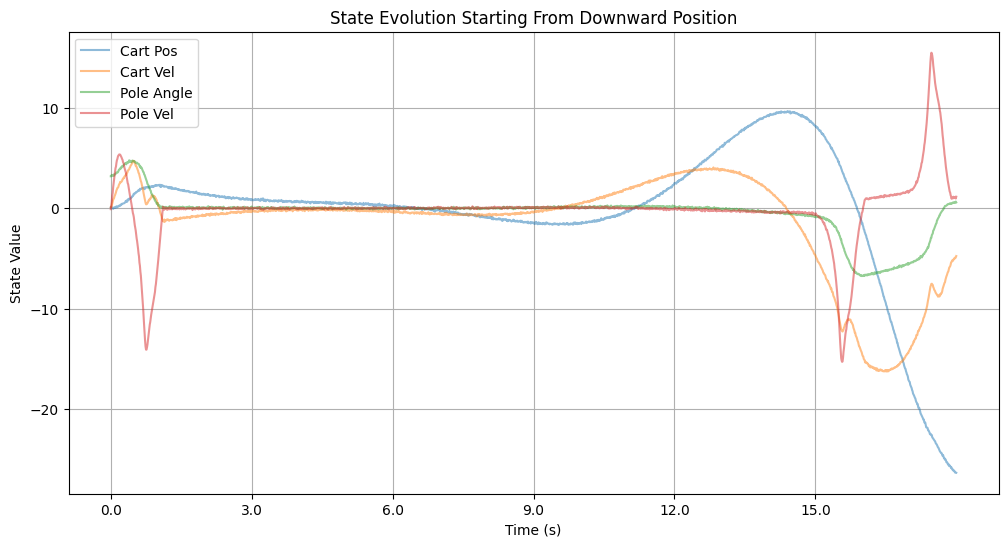

In [112]:
# Run rollout with optimized policy
T_plot = T
T_plot = 1800
states, actions = env_jax.rollout(initial_state, learned_policy, T_plot)

# Convert to NumPy for plotting
states_np = np.array(states)
actions_np = np.array(actions)

# Plot state variables over time
plt.figure(figsize=(12, 6))
labels = ["Cart Pos", "Cart Vel", "Pole Angle", "Pole Vel"]
for i in range(4):
    plt.plot(states_np[:, i], label=labels[i], alpha=0.5)
# plt.plot(states_np[:, 2], label=labels[2])

plt.title("State Evolution Starting From Downward Position")
# plt.xlabel("Timestep")
plt.xlabel("Time (s)")
xticks = np.arange(0, T_plot)
plt.xticks(ticks=xticks[::300], labels=(xticks[::300] * env_jax.params["delta_time"]))

plt.ylabel("State Value")
plt.legend()
plt.grid(True)
plt.savefig('4.1_downward.png')
plt.show()

### Model-Based Policy Optimization

In [113]:
def feature_extension_jax(x):
    if x.ndim == 1:
        if x.shape[0] == 6:
            print("feature already extended")
            return x
        elif x.shape[0] == 5:
            x0, x1, theta, x3, x4 = x
            return jnp.array([x0, x1, jnp.sin(theta), jnp.cos(theta), x3, x4])
    elif x.ndim == 2:
        if x.shape[1] == 6:
            print("feature already extended")
            return x
        elif x.shape[1] == 5:
            x0 = x[:, 0]
            x1 = x[:, 1]
            theta = x[:, 2]
            x3 = x[:, 3]
            x4 = x[:, 4]
            return jnp.stack([x0, x1, jnp.sin(theta), jnp.cos(theta), x3, x4], axis=1)
    
    raise ValueError(f"include_jax FAILED: unexpected input shape {x.shape}")

In [114]:
def jax_rbf_kernel(x1, x2, sigma):
    """x1, x2 shape: (batch, features), sigma: (features,) or scalar"""
    x1 = feature_extension_jax(x1)
    x2 = feature_extension_jax(x2)
    diff = x1 - x2
    scaled_diff = diff / sigma
    return jnp.exp(-0.5 * jnp.sum(scaled_diff**2))

In [115]:
def compute_kernel_vec(input_vec, kernel_centers, sigma):
    return jax.vmap(lambda kc: jax_rbf_kernel(input_vec, kc, sigma))(kernel_centers)

In [116]:
@jit
def model_step(state, action, kernel_centers, alpha_opt, sigma_opt):
    input_vec = jnp.concatenate([state, jnp.array([action])])
    Kmn = compute_kernel_vec(input_vec, kernel_centers, sigma_opt)
    delta = Kmn @ alpha_opt
    return state + delta

In [117]:
@jit
def model_rollout_jax(initial_state, P, kernel_centers, alpha_opt, sigma_opt):
    T = 400
    
    def scan_fn(state, _):
        action = policy_fn(P, state)
        next_state = model_step(state, action, kernel_centers, alpha_opt, sigma_opt)
        return next_state, next_state
    
    _, states = lax.scan(scan_fn, initial_state, None, length=T)
    return jnp.vstack([initial_state[None, :], states])

In [118]:
@jit
def rollout_loss_jax(P, initial_state, kernel_centers, alpha_opt, sigma_opt, sig):
    states = model_rollout_jax(initial_state, P, kernel_centers, alpha_opt, sigma_opt)
    losses = jax.vmap(lambda s: jax_loss(s, sig))(states)
    return jnp.sum(losses)

In [119]:
loss_and_grad = value_and_grad(rollout_loss_jax, argnums=0)

def scipy_loss_fn(P_np):
    P = jnp.array(P_np)
    val, grad_val = loss_and_grad(
        P,
        initial_state,
        kernel_centers,
        alpha_opt,
        sigma_opt,
        sig
    )
    return float(val), jnp.array(grad_val)
    # return float(val)

#### Verify Model Rollout

In [640]:
# init_state = np.array([-2.0, 3.0, 1.0, -3.0])
# action = 2.0
# env.setState(init_state.copy())
# init_state_act = np.append(init_state.copy(), np.array([action]))
# print(f'initial state: {init_state_act}')

# num_steps = 60
# states = [init_state.copy()]
# pred_states = [np.append(init_state.copy(), np.array([action]))]
# state = jnp.array(init_state.copy())

# for _ in range(num_steps):
#     # True step
#     env.performAction(action=action)
#     states.append(env.getState().copy())

#     # GP-predicted step (JAX)
#     next_state = model_step(state, action, kernel_centers, alpha_opt, sigma_opt)
#     state = next_state.copy()  # update for next iteration
#     action = 0.0
#     pred_states.append(np.append(np.array(state.copy()), action))  # convert to NumPy

# # Convert to arrays for plotting
# states = np.array(states)
# pred_states = np.array(pred_states)

In [639]:
# time = [i * env.delta_time for i in range(num_steps+1)]
# labels = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']
# title = f'initial state: {init_state_act}'

# for i in range(len(states[0])):
#     plt.figure(figsize=(6, 4))
#     plt.plot(time, states[:, i], label='True Evolution', color='blue')
#     plt.plot(time, pred_states[:, i], label='Predicted Evolution', color='red', linestyle='--')
#     plt.title(title)
#     plt.ylabel(labels[i])
#     plt.xlabel('Time (seconds)')
#     plt.legend()
#     plt.grid(True)

# # Phase plots
# fig1, ax1 = plt.subplots(figsize=(6, 4))
# lc1 = plot_colored_phase(ax1, states[:, 1], states[:, 3], "True Phase Trajectory")
# plt.colorbar(lc1, ax=ax1, label='Time (Seconds)')

# fig2, ax2 = plt.subplots(figsize=(6, 4))
# lc2 = plot_colored_phase(ax2, pred_states[:, 1], pred_states[:, 3], "Predicted Phase Trajectory")
# plt.colorbar(lc2, ax=ax2, label='Time (Seconds)')

# plt.show()

#### Optimization

In [126]:
initial_state = jnp.array([0.0, 0.0, jnp.pi+0.05, -0.1])
sig = jnp.array([15.0,15.0,1.5,1.5])
P0 = np.array([1.2, 0.3, 10, 10 ])

# initial_state = jnp.array([0.0, 0.0, 0.5, 0.0])
# sig = jnp.array([10., 10., 4., 8.])
# P0 = np.array([ 1, 1,  20,  5])

result = minimize(
    scipy_loss_fn,
    P0,
    method='L-BFGS-B',
    jac=True,
    options={'disp': True}
)

P_opt = result.x


In [127]:
print(P_opt)

[-0.3464499  -0.26814742 11.46025113  9.26068856]


Using P_opt: [-0.3464499  -0.26814742 11.46025113  9.26068856]


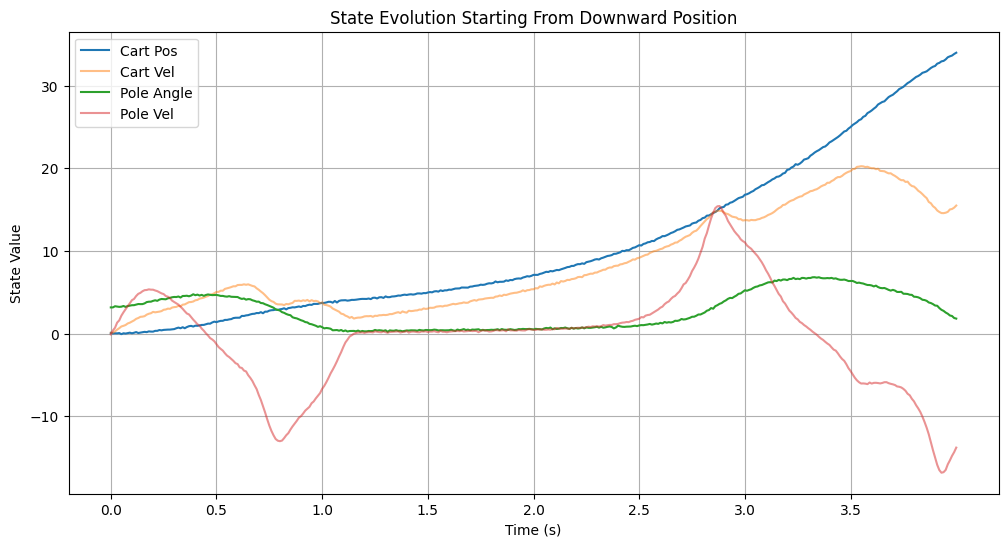

In [129]:
T_plot = 400
# Run rollout with optimized policy
states, actions = env_jax.rollout(initial_state, learned_policy, T_plot)

# Convert to NumPy for plotting
states_np = np.array(states)
actions_np = np.array(actions)

# Plot state variables over time
plt.figure(figsize=(12, 6))
labels = ["Cart Pos", "Cart Vel", "Pole Angle", "Pole Vel"]
for i in range(4):
    if (i == 3 or i == 1):
        plt.plot(states_np[:, i], label=labels[i], alpha=0.5)
    else:
        plt.plot(states_np[:, i], label=labels[i])
# plt.plot(states_np[:, 2], label=labels[2])

plt.title("State Evolution Starting From Downward Position")
# plt.xlabel("Timestep")
plt.xlabel("Time (s)")
xticks = np.arange(0, T_plot)
plt.xticks(ticks=xticks[::50], labels=(xticks[::50] * env_jax.params["delta_time"]))

plt.ylabel("State Value")
plt.legend()
plt.grid(True)
# plt.savefig('4.1_downward_model.png')
plt.show()